# Машинное обучение

## Факультет математики НИУ ВШЭ

### 2019-2020 учебный год

Илья Щуров, Соня Дымченко, Руслан Хайдуров, Александр Каган, Павел Балтабаев

# Семинар 16

# Матричные разложения и компонентный анализ
---

In [71]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px

np.random.seed(4)

# Singular Value Decomposition


Сингулярное разложение матрицы $M$ (complex or real matrix $m\times n$) это разложение вида $U\Sigma V^*$, где $U$ - унитарная матрица $m\times m$ левых сингулярных векторов (собственные векторы матрицы $MM^*$), $\Sigma$ - прямоугольная диагональная матрица  $m\times n$ с неотрицательными действительными числами на диагонали (сингулярные значения), $V$ - унитарная матрица $n\times n$ правых сингулярных векторов (собственные векторы матрицы $M^*M$). Если $M$ - вещественная, то $U, V^T$ ортонормированные вещественные матрицы.

Простыми словами, это разложение матрицы на **ортогональные столбцы и вектора** и диагональную матрицу, которая обозначает **значимость** каждого фактора.


### Compact SVD 
![SVD](https://raw.githubusercontent.com/fastai/course-nlp/85e505295efeed88ce61dc0ff5e424bde9741a15/images/svd_fb.png)

(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

SVD широко используется в линейной алгебре и достаточно популярно применяется в дата сайенсе:
- метод главных компонент
- семантически анализ (NLP)
- сжатие данных
- коллаборативная фильтрация (рекомендации, [Netflix Prize](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf))
- Мур-Пенроуз (псевдообратная матрица)



# PCA

Кратко вспомним, что делает этот метод (подробно см. в лекции).

Обозначим $X$ &mdash; матрица объекты-признаки, с нулевым средним каждого признака,
а $w$ &mdash; некоторый единичный вектор. Тогда
$Xw$ задает величину проекций всех объектов на этот вектор. Далее ищется вектор,
который дает наибольшую дисперсию полученных проекций (то есть наибольшую дисперсию
вдоль этого направления):

$$
    \max_{w: \|w\|=1} \| Xw \|^2 =  \max_{w: \|w\|=1} w^T X^T X w
$$

Подходящий вектор тогда равен собственному вектору матрицы $X^T X$ с наибольшим собственным
значением. После этого все пространство проецируется на ортогональное дополнение к вектору
$w$ и процесс повторяется.

## PCA с помощью SVD

In [72]:
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [73]:
fig = px.scatter_3d(X, x=0, y=1, z=2)
fig.show()

In [74]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

In [75]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [76]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [77]:
# первые две компоненты
W2 = Vt.T[:, :2]
X2D_svd = X_centered.dot(W2)

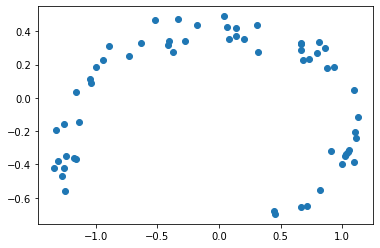

In [78]:
plt.scatter(X2D_svd[:,0], X2D_svd[:,1])
plt.show()

## PCA из sklearn

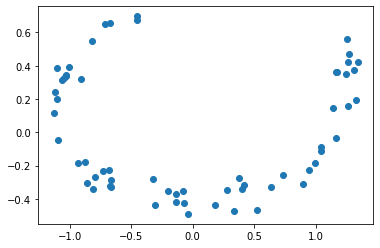

In [79]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
plt.scatter(X2D[:,0], X2D[:,1])
plt.show()

Обратите внимание, что многократное выполнение PCA на немного разных наборах данных может привести к различным результатам (это не уникальное решение). В общем, единственная разница заключается в том, что некоторые оси могут быть перевернуты. В этом примере PCA, использующий Scikit-Learn, дает ту же проекцию, что и в подходе SVD, за исключением того, что обе оси перевернуты:

In [80]:
np.allclose(X2D, -X2D_svd)

True

Теперь восстановим в исходное пространство:

In [81]:
X3D_inv = pca.inverse_transform(X2D)

Конечно, на этапе проекции произошла некоторая потеря информации, поэтому восстановленные 3D-точки не совсем равны исходным 3D-точкам:

In [82]:
np.allclose(X3D_inv, X)

False

Посчитаем ошибку:

In [83]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

Обратная операция для SVD-подхода выглядит так:

In [84]:
X3D_svd_inv = X2D_svd.dot(Vt[:2, :])

Реконструкции из обоих методов не идентичны, потому что класс Scikit-Learn `PCA` автоматически заботится об обратном среднем центрировании, но если мы вычитаем среднее, то получим ту же самую реконструкцию:

In [87]:
np.allclose(X3D_svd_inv, X3D_inv - pca.mean_)

True

Теперь давайте посмотрим на `explained variance ratio` - дисперсия, объясненная каждой компонентой (относительно):

In [88]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

Первая компонента объясняет 84.2% дисперсии, а вторая 14.6%.

То есть проектирую наше 3D в 2D, мы теряем всего около 1.1% дисперсии:

In [89]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Для SVD-подхода тоже можем такое посчитать (собственные значения):

In [91]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

### Компоненты наглядно

В результате работы PCA из sklearn в `.components_` будут лежать главные направления (нормированные), а в `.explained_variance_` &mdash; дисперсия, которую объясняет каждая компонента. Изобразим на нашем графике эти направления, умножив их на дисперсию для наглядного отображения их значимости.

In [99]:
def PCA_show(dataset):
    plt.scatter(*zip(*dataset), alpha=0.5)
    
    dec = PCA()
    dec.fit(dataset)
    ax = plt.gca()
    for comp_ind in range(dec.components_.shape[0]):
        component = dec.components_[comp_ind, :]
        var = dec.explained_variance_[comp_ind]
        start, end = dec.mean_, component * var
        ax.arrow(start[0], start[1], end[0], end[1],
                 head_width=0.1, head_length=0.2, fc='r', ec='r')
    
    ax.set_aspect('equal', adjustable='box')

In [100]:
# возьмем гауссиану
np.random.seed(4242)

data_synth = np.random.multivariate_normal(
    mean=[0, 0], 
    cov=[[4, 0], 
         [0, 1]],
    size=1000)

angle = np.pi / 6
rotate = np.array([
        [np.cos(angle), - np.sin(angle)],
        [np.sin(angle), np.cos(angle)],
    ])
data_synth_r = rotate.dot(data_synth.T).T

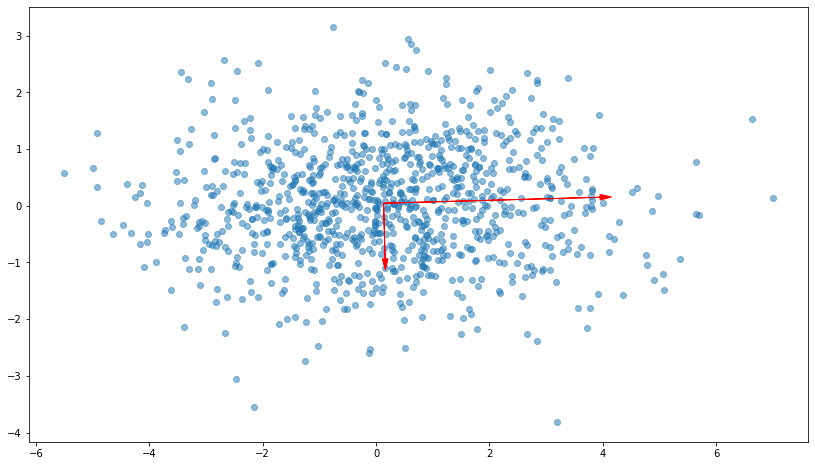

In [101]:
plt.figure(figsize=(16, 8))
PCA_show(data_synth)

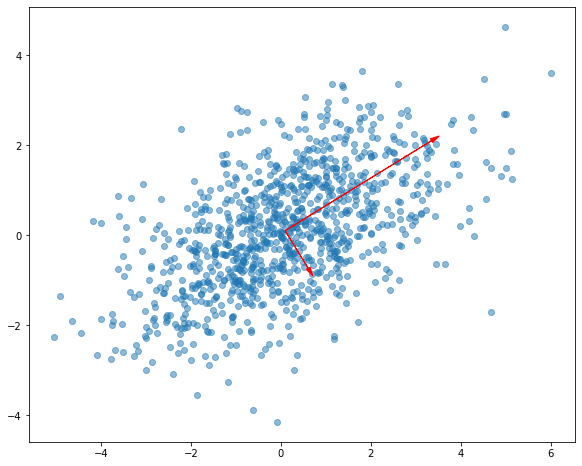

In [102]:
plt.figure(figsize=(16, 8))
PCA_show(data_synth_r)

### Пример для разных "видов" данных

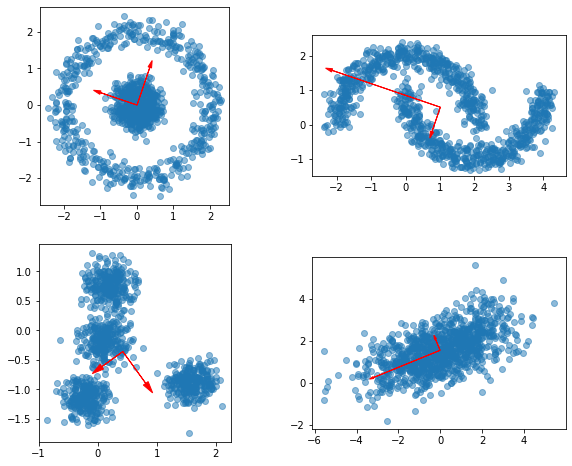

In [103]:
from sklearn.datasets import make_circles, make_moons, make_blobs

data_synth_bad = [
    make_circles(n_samples=1000, factor=0.2, noise=0.1)[0]*2,
    make_moons(n_samples=1000, noise=0.1)[0]*2,
    make_blobs(n_samples=1000, n_features=2, centers=4)[0]/5,
    np.random.multivariate_normal(
        mean=[0, 1.5], 
        cov=[[3, 1], 
             [1, 1]],
        size=1000),
]

plt.figure(figsize=(10,8))
rows, cols = 2, 2
for i, data in enumerate(data_synth_bad):
    plt.subplot(rows, cols, i + 1)
    PCA_show(data)

### PCA с ядрами

Так как PCA фактически работает не исходными признаками, а с матрицей их ковариаций, можно
использовать для ее вычисления вместо скалярного произведения $\langle x_i, x_j \rangle$ произвольное
ядро $K(x_i, x_j)$. Это будет соответствовать переходу в другое пространство, в котором
наше предположение о линейности уже будет иметь смысл. Единственная проблема &mdash; непонятно, как
подбирать ядро.

Ниже приведены примеры объектов в исходном пространстве (похожие группы обозначены одним цветом
для наглядности), и результат их трансформации в новые пространства (для разных ядер). Если результаты
получаются линейно разделимыми &mdash; значит мы выбрали подходящее ядро.

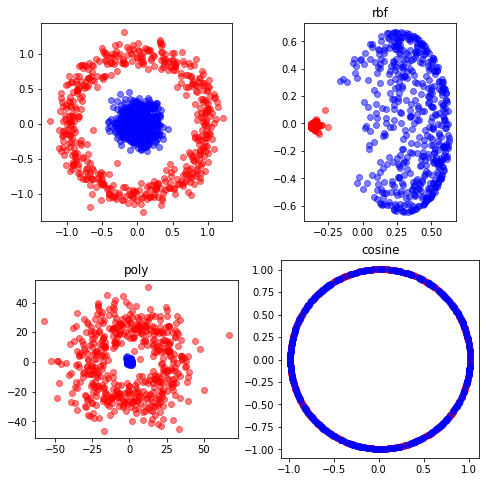

In [108]:
from sklearn.decomposition import KernelPCA

def KPCA_show(X, y):
    reds = y == 0
    blues = y == 1
    
    plt.figure(figsize=(8, 8))
    rows, cols = 2, 2
    plt.subplot(rows, cols, 1)
    plt.scatter(X[reds, 0], X[reds, 1], alpha=0.5, c='r')
    plt.scatter(X[blues, 0], X[blues, 1], alpha=0.5, c='b')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    
    kernels_params = [
        dict(kernel='rbf', gamma=10),
        dict(kernel='poly', gamma=10),
        dict(kernel='cosine', gamma=10),
    ]
    
    for i, p in enumerate(kernels_params):
        dec = KernelPCA(**p)
        X_transformed = dec.fit_transform(X)
        
        plt.subplot(rows, cols, i + 2)
        plt.title(p['kernel'])
        plt.scatter(X_transformed[reds, 0], X_transformed[reds, 1], alpha=0.5, c='r')
        plt.scatter(X_transformed[blues, 0], X_transformed[blues, 1], alpha=0.5, c='b')
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
        
np.random.seed(4242)
KPCA_show(*make_circles(n_samples=1000, factor=0.2, noise=0.1))

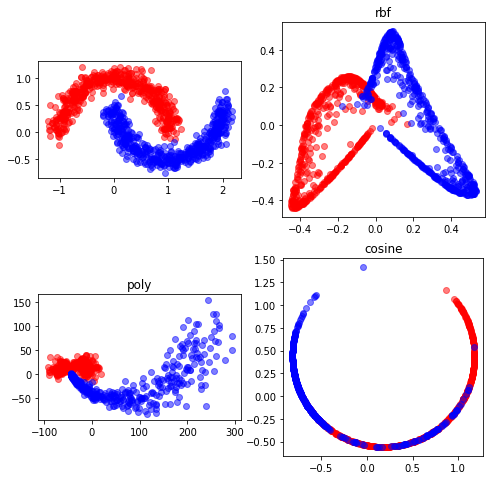

In [109]:
np.random.seed(4242)
KPCA_show(*make_moons(n_samples=1000, noise=0.1))

# Eigenfaces & Decompression

Рассмотрим датасет с фотографиями лиц людей и применим к его признакам PCA.

Ниже изображены примеры лиц из базы, и последняя картинка &mdash; это "среднее лицо".

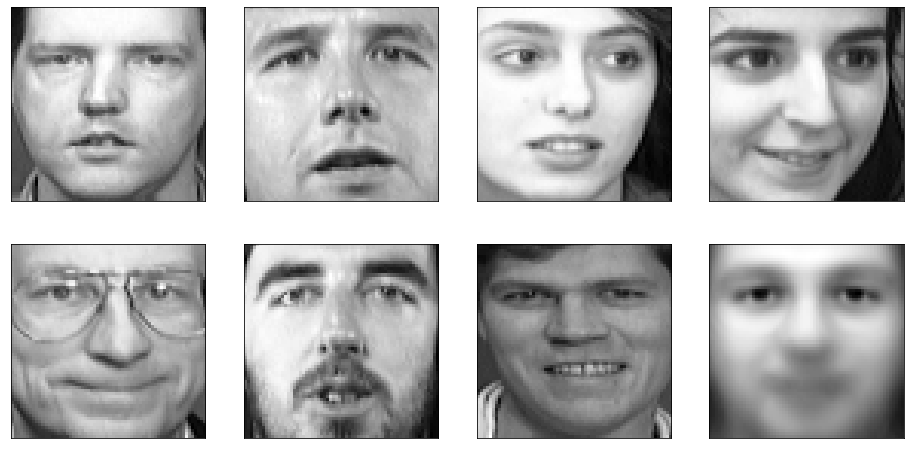

In [168]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle=True, random_state=432542)
faces_images = faces.data
faces_ids = faces.target
image_shape = (64, 64)
    
mean_face = faces_images.mean(axis=0)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples - 1):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(faces_images[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
plt.subplot(rows, cols, n_samples)
plt.imshow(mean_face.reshape(image_shape), interpolation='none',
           cmap='gray')
plt.xticks(())
_ = plt.yticks(())

Теперь найдем главные компоненты

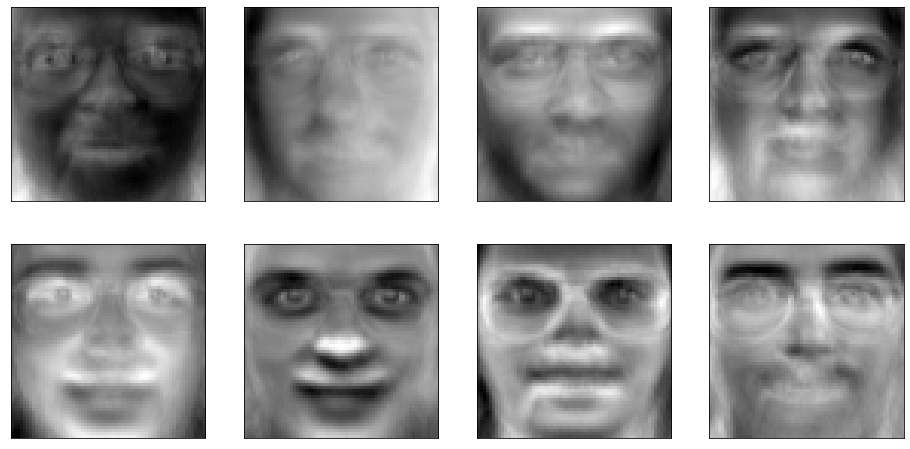

In [173]:
red = PCA()
faces_images -= mean_face
red.fit(faces_images)

plt.figure(figsize=(16, 8))
rows, cols = 2, 4
n_samples = rows * cols
for i in range(n_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(red.components_[i, :].reshape(image_shape), interpolation='none',
               cmap='gray')
    plt.xticks(())
    plt.yticks(())

Получилось жутковато, что уже неплохо, но есть ли от этого какая-то польза?

Во-первых, новые признаки дают более высокое качество классификации.

In [174]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

gscv_rf = GridSearchCV(RandomForestClassifier(),
                       {'n_estimators': [100, 200, 500, 800], 'max_depth': [2, 3, 4, 5]},
                       cv=5)

In [175]:
%%time

gscv_rf.fit(faces_images, faces_ids)
print(gscv_rf.best_score_)

0.8025
CPU times: user 2min 53s, sys: 484 ms, total: 2min 54s
Wall time: 2min 54s


In [176]:
%%time

gscv_rf.fit(red.transform(faces_images)[:,:100], faces_ids)
print(gscv_rf.best_score_)

0.9100000000000001
CPU times: user 1min 5s, sys: 766 ms, total: 1min 5s
Wall time: 1min 4s


Во-вторых, их можно использовать для компактного хранения данных. Для этого объекты трансформируются
в новое пространство, и из него выкидываются самые незначимые признаки.

Ниже приведены результаты сжатия в 10 раз.

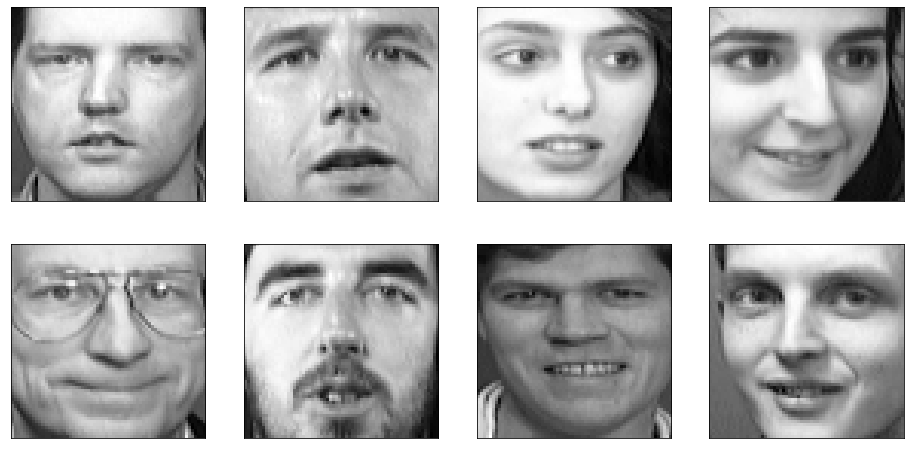

In [179]:
base_size = image_shape[0] * image_shape[1]

def compress_and_show(compress_ratio):
    red = PCA(n_components=int(min(faces_images.shape[0], base_size * compress_ratio)))
    red.fit(faces_images)

    faces_compressed = red.transform(faces_images)
    faces_restored = red.inverse_transform(faces_compressed) + mean_face

    plt.figure(figsize=(16, 8))
    rows, cols = 2, 4
    n_samples = rows * cols
    for i in range(n_samples):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(faces_restored[i, :].reshape(image_shape), interpolation='none',
                   cmap='gray')
        plt.xticks(())
        plt.yticks(())
        
compress_and_show(0.1)

И даже при сжатии в 20 раз лица остаются узнаваемыми.

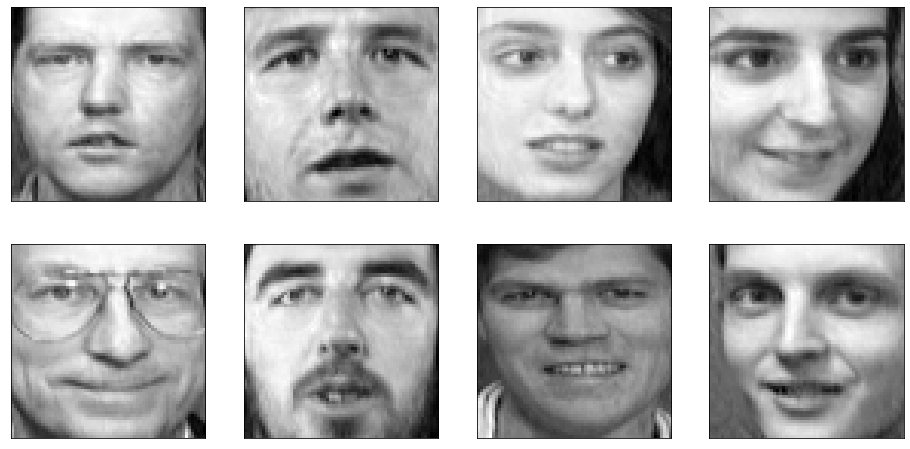

In [180]:
compress_and_show(0.05)

# Topic Modeling (LSA)

Начнем с **term-document matrix**:
![term-doc](https://github.com/fastai/course-nlp/raw/85e505295efeed88ce61dc0ff5e424bde9741a15/images/document_term.png)

source: [Introduction to Information Retrieval](http://player.slideplayer.com/15/4528582/#)


С помощью нашего SVD мы можем разложить это на одну высокую тонкую матрицу, умноженную на одну широкую короткую матрицу (возможно, с диагональной матрицей между ними).

Обратите внимание, что это представление не учитывает порядок слов или структуру предложения. Это пример подхода мешок слов.

### Мотивация

Рассмотрим самый крайний случай - восстановление матрицы с помощью внешнего произведения двух векторов. Очевидно, что в большинстве случаев мы не сможем точно восстановить матрицу. Но если бы у нас был один вектор с относительной частотой каждого словарного слова из общего количества слов и один со средним числом слов в документе, то это произведение было бы настолько близко, насколько мы можем получить.

Теперь рассмотрим увеличение этой матрицы до двух столбцов и двух строк. Теперь оптимальным способом декомпозиции будет объединение документов в две группы, каждая из которых имеет максимально различное распределение слов по отношению друг к другу (ортогональные темы), но максимально схожее между документами в кластере. Мы будем называть эти две группы "темами". И мы бы сгруппировали слова в две группы, основываясь на тех, которые наиболее часто появляются в каждой из тем.

## Приступим!

Мы возьмем набор данных документов в нескольких различных категориях и найдем для них темы (состоящие из групп слов). Знание реальных категорий помогает нам оценить, имеют ли смысл те темы, которые мы находим.

In [11]:
import numpy as np
from sklearn import decomposition
from scipy import linalg

Наш датасет - это дискуссионные группы на Usenet, которые были популярны в 80-е и 90-е годы, прежде чем интернет действительно взлетел. Этот набор данных включает в себя 18 000 сообщений в группах новостей с 20 темами.

In [118]:
from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [119]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

Давайте посмотрим на некоторые данные. Можете ли вы догадаться, к какой категории относятся эти сообщения?

In [122]:
print(f"\n{'-'*100}\n".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
----------------------------------------------------------------------------------------------------


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrat

In [123]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

Таргет это номер категории

In [124]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

In [125]:
num_topics, num_top_words = 6, 8

In [126]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk

vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape

(2034, 26576)

In [161]:
vocab = np.array(vectorizer.get_feature_names())
vocab.shape

(26576,)

In [162]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel',
       'counselees', 'counselor', 'count'], dtype='<U80')

### LSA с помощью  SVD

In [131]:
%time U, s, Vh = np.linalg.svd(vectors, full_matrices=False)

CPU times: user 2min 11s, sys: 20.1 s, total: 2min 31s
Wall time: 22.6 s


In [132]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


#### Темы

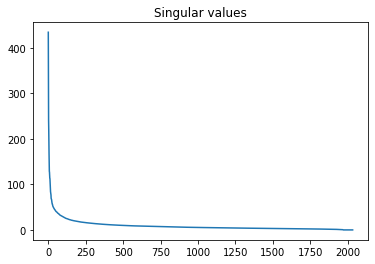

In [134]:
plt.plot(s)
plt.title('Singular values')
plt.show()

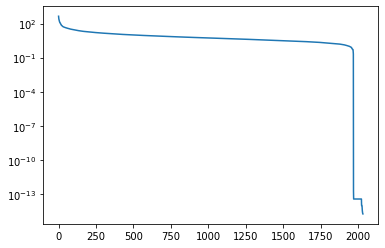

In [136]:
plt.semilogy(s)
plt.show()

In [157]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [160]:
show_topics(np.array(Vh)[:10])

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

Мы получаем темы, которые соответствуют типам кластеров, которые мы ожидаем! Это несмотря на то, что это **алгоритм обучения без учителя** - то есть мы никогда не говорили алгоритму, как группируются наши документы.

# t-SNE, LDA, LLE, PCA на MNIST-датасете

In [91]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx].astype(int)


In [92]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    X_normalized = MinMaxScaler().fit_transform(X)
    neighbors = np.array([[10., 10.]])
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

## PCA

PCA took 0.3s.


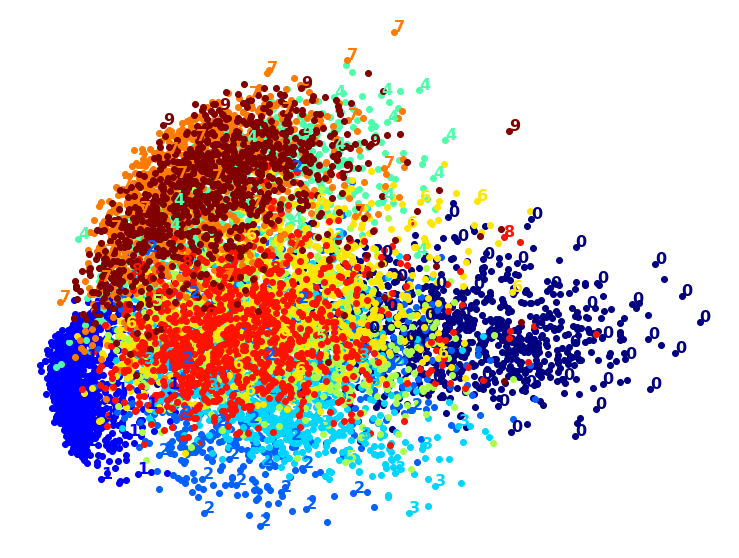

In [93]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

Ничего себе, невероятно быстро! Но хотя мы и видим несколько кластеров, здесь слишком много наложений кластеров. 

## LLE

LLE took 145.7s.


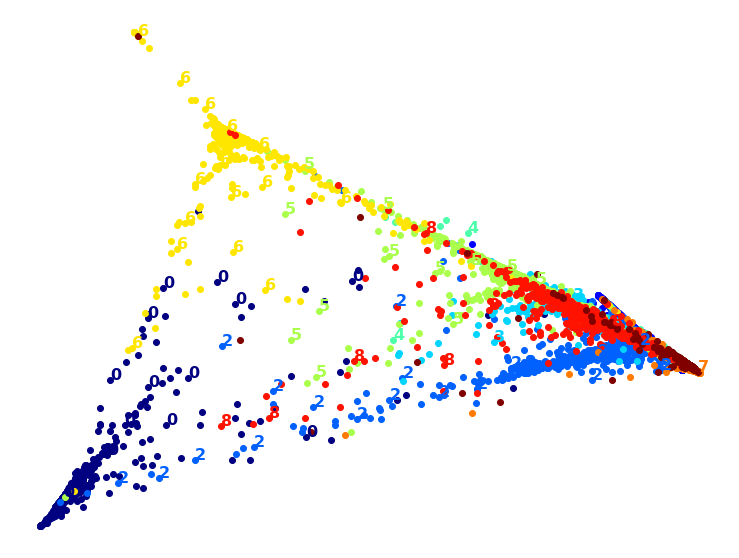

In [94]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

Это заняло некоторое время, и результат выглядит не слишком хорошо. Давайте посмотрим, что произойдет, если мы сначала применим PCA, сохранив 95% дисперсии:

PCA+LLE took 43.3s.


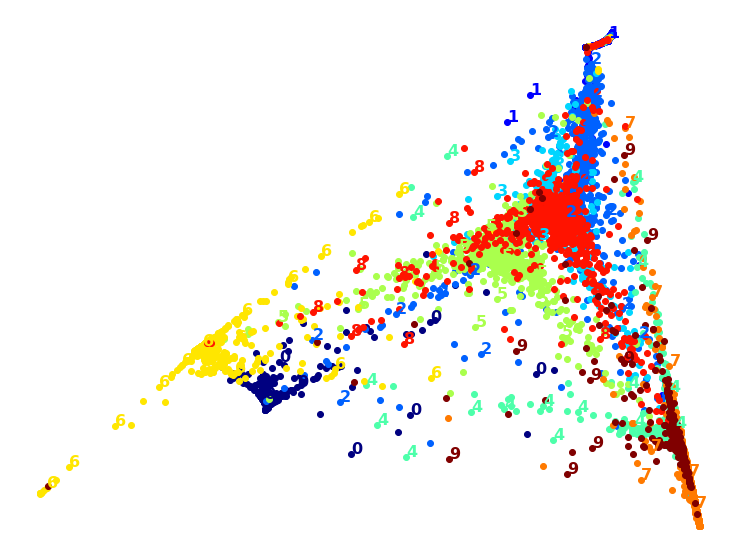

In [95]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

Примерно то же самое, но побыстрее.

## LDA

LDA took 1.7s.


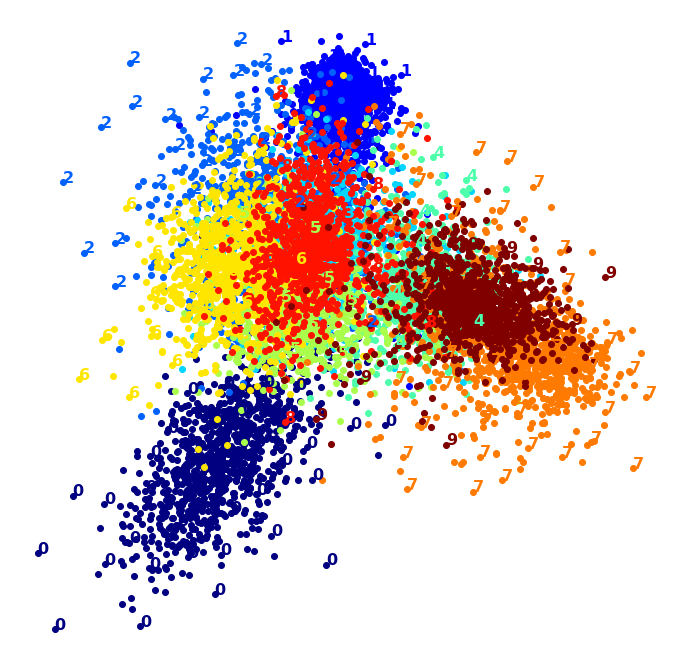

In [96]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA took {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

Довольно быстро, но много наложений.

## t-SNE

t-SNE took 218.2s.


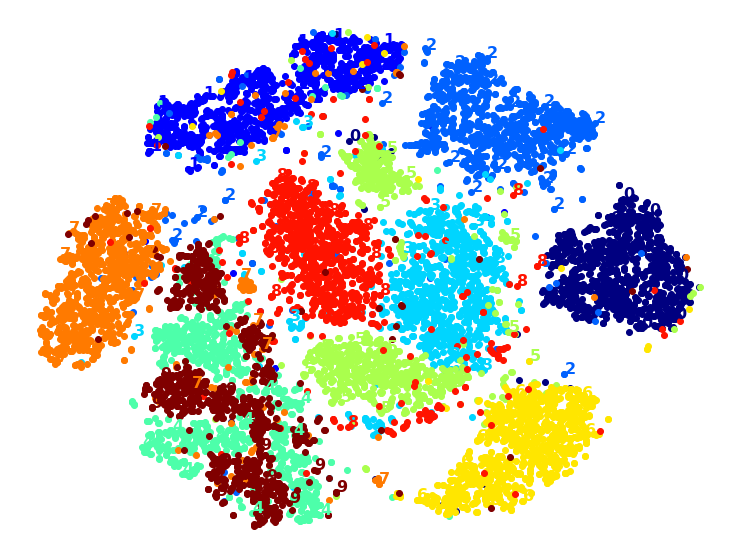

In [97]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

Результат отличный, однако долго.

PCA+t-SNE took 135.8s.


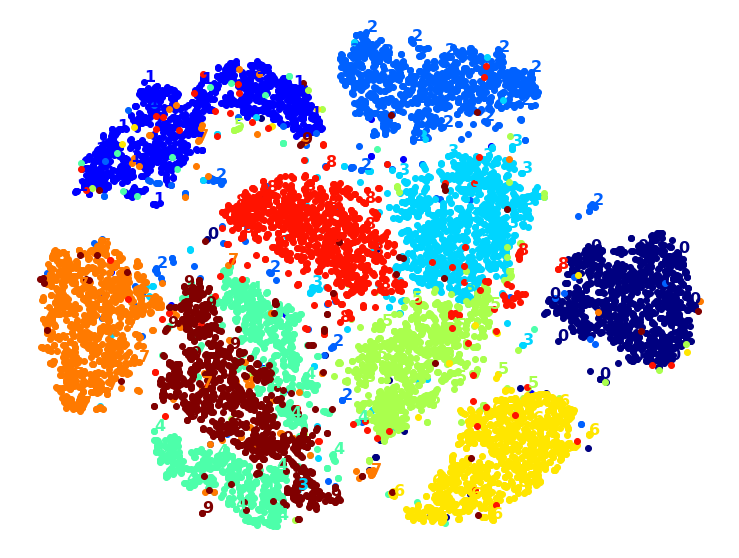

In [98]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.9, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

Стало быстрее, результат так же хорош!